# Car Price

O objetivo desse projeto é criar um modelo que estime o preço (Price) de carros com base em algumas variáveis (Brand, Model, Year, Engine Size, Fuel Type, Transmission, Mileage, Doors e Owner Count). Também é de interesse entender como cada variável colabora com os preços além de criar visualizações para gerar insights.

## Importações

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error

## Dataset
https://www.kaggle.com/datasets/asinow/car-price-dataset

In [ ]:
df = pd.read_csv('../data/car_price_dataset.csv', sep=',')

## Limpeza de Dados

Primeiro verificaremos os dados

In [ ]:
df.head()

,Brand,Model,Year,Engine_Size,Fuel_Type,Transmission,Mileage,Doors,Owner_Count,Price
0,Kia,Rio,2020,4.2,Diesel,Manual,289944,3,5,8501
1,Chevrolet,Malibu,2012,2.0,Hybrid,Automatic,5356,2,3,12092
2,Mercedes,GLA,2020,4.2,Diesel,Automatic,231440,4,2,11171
3,Audi,Q5,2023,2.0,Electric,Manual,160971,2,1,11780
4,Volkswagen,Golf,2003,2.6,Hybrid,Semi-Automatic,286618,3,3,2867


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Brand         10000 non-null  object 
 1   Model         10000 non-null  object 
 2   Year          10000 non-null  int64  
 3   Engine_Size   10000 non-null  float64
 4   Fuel_Type     10000 non-null  object 
 5   Transmission  10000 non-null  object 
 6   Mileage       10000 non-null  int64  
 7   Doors         10000 non-null  int64  
 8   Owner_Count   10000 non-null  int64  
 9   Price         10000 non-null  int64  
dtypes: float64(1), int64(5), object(4)
memory usage: 781.4+ KB


É possível visualizar que não existem valores nulos

In [ ]:
print(f'Registros Duplicados: {df.duplicated().sum()}')

Registros Duplicados: 0


Também não existem registros duplicados

Verificaremos se existe alguma anomalia nas variáveis numéricas (Year, Engine_Size, Mileage, Doors, Owner_Count e Price) através de gráficos Boxplot

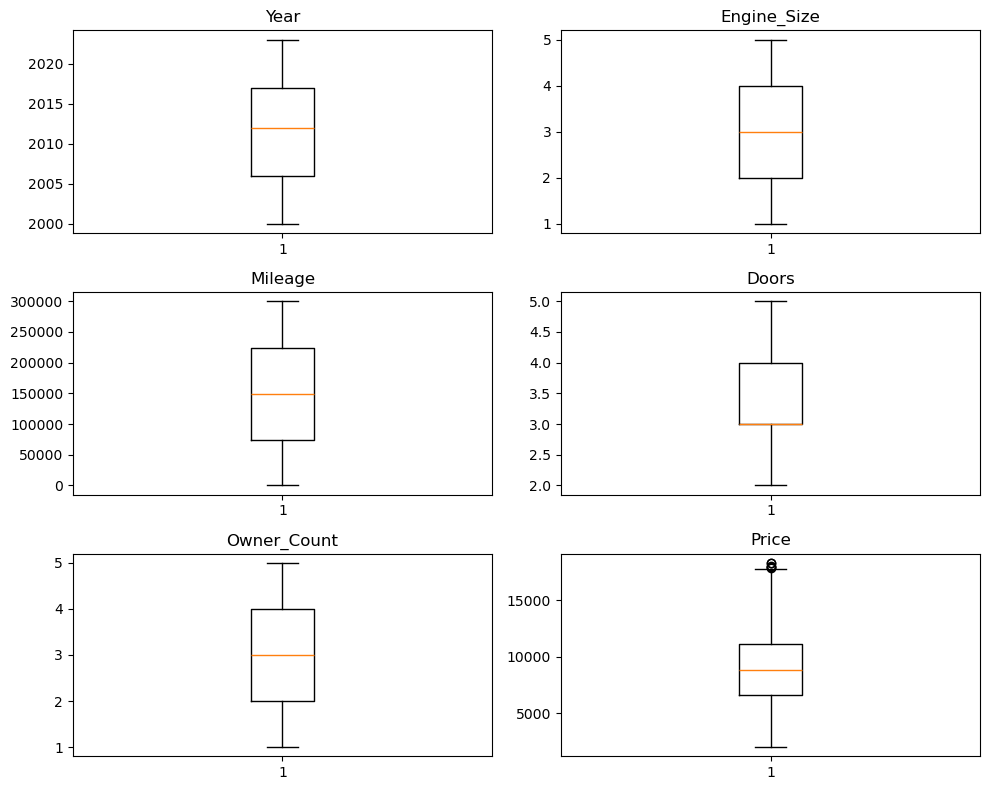

In [ ]:
plt.figure(figsize=(10,8))

plt.subplot(3, 2, 1)
plt.boxplot(df['Year'])
plt.title('Year')

plt.subplot(3, 2, 2)
plt.boxplot(df['Engine_Size'])
plt.title('Engine_Size')

plt.subplot(3, 2, 3)
plt.boxplot(df['Mileage'])
plt.title('Mileage')

plt.subplot(3, 2, 4)
plt.boxplot(df['Doors'])
plt.title('Doors')

plt.subplot(3, 2, 5)
plt.boxplot(df['Owner_Count'])
plt.title('Owner_Count')

plt.subplot(3, 2, 6)
plt.boxplot(df['Price'])
plt.title('Price')

plt.tight_layout()
plt.show()

Apesar de existirem alguns outliers na variável dependente Price, os valores não são extremos o suficiente para serem considerados anomalias. As outras variáveis analisadas não possuem outliers

## Análise Exploratória de Dados

### Observando correlações entre variáveis numéricas

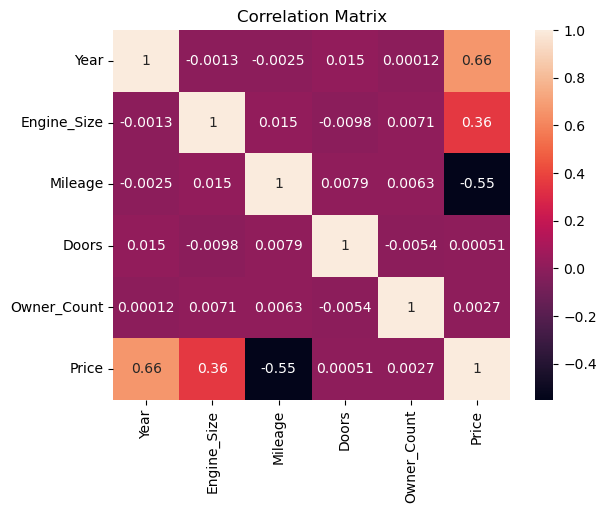

In [ ]:
corr_matrix = df[['Year', 'Engine_Size', 'Mileage', 'Doors', 'Owner_Count', 'Price']].corr()
plt.title('Correlation Matrix')
sns.heatmap(corr_matrix, annot=True);

Pela matriz de correlação é possível notar que a variável Price possui algumas correlações significativas.  
Possui correlação positiva de 0.66 com Year.  
Possui correlação positiva de 0.36 com Engine_Size.  
Possui correlação negativa de -0.55 com Mileage.

Iremos analisar melhor a correlação com essas três variáveis atraveś do gráfico Hexbin (já que o gráfico Scatter ficaria muito condensado pela quantidade de dados)

In [ ]:
def plot_hexbin_fit(ax, data, x, y):
    ax.set_xlabel(x)
    ax.set_ylabel(y)

    ax.hexbin(data[x], data[y], cmap='Blues', gridsize=30)

    coef = np.polyfit(data[x], data[y], 1)
    poly1d_fn = np.poly1d(coef)

    x_vals = np.linspace(data[x].min(), data[x].max(), 100)
    ax.plot(x_vals, poly1d_fn(x_vals), color='red', linestyle='--', linewidth=2)


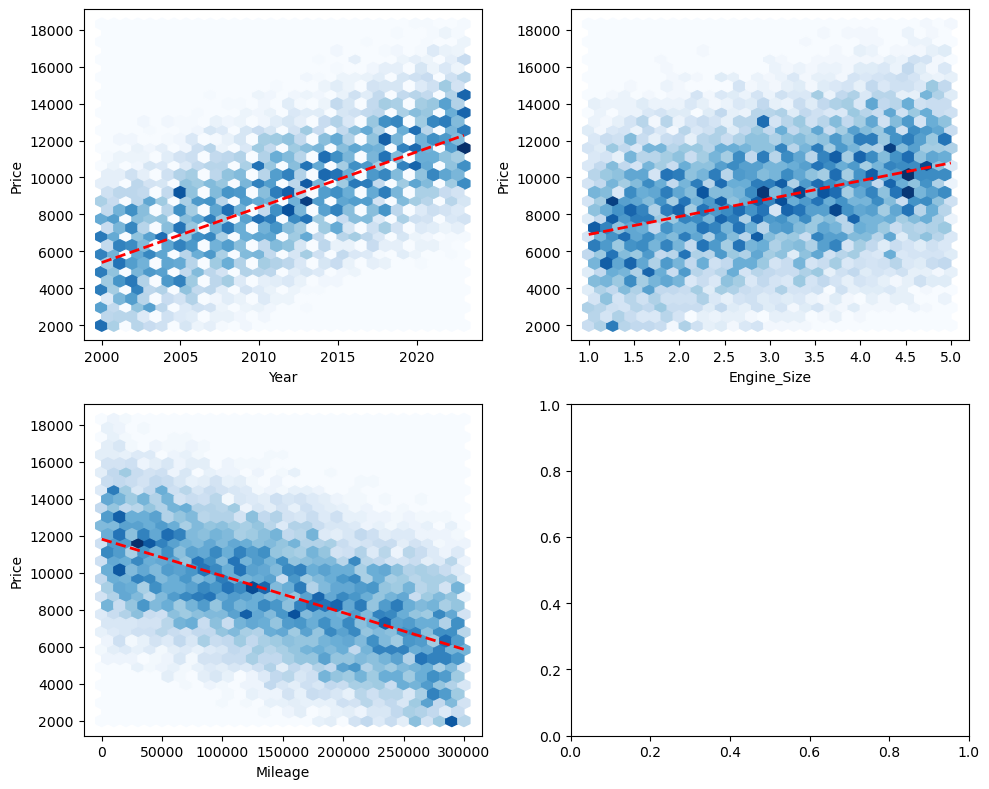

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8))

plot_hexbin_fit(ax[0,0], df, 'Year', 'Price')
plot_hexbin_fit(ax[0,1], df, 'Engine_Size', 'Price')
plot_hexbin_fit(ax[1,0], df, 'Mileage', 'Price')

plt.tight_layout()
plt.show()

### Analisando variáveis categóricas

Primeiramente iremos analisar o preço médio para cada categoria da variável Transmission em cada ano

In [ ]:
mean_price_by_transmission = df.groupby(['Transmission', 'Year'])['Price'].mean()
mean_price_by_transmission

Transmission    Year
Automatic       2000     6566.581967
                2001     7015.811024
                2002     6779.692308
                2003     7410.134921
                2004     7496.068702
                            ...     
Semi-Automatic  2019    10410.934426
                2020    11149.407692
                2021    11039.783333
                2022    11459.649635
                2023    11652.197080
Name: Price, Length: 72, dtype: float64

In [ ]:
print(df['Transmission'].unique())

['Manual' 'Automatic' 'Semi-Automatic']


In [ ]:
mean_price_automatic = mean_price_by_transmission.loc['Automatic']
mean_price_semiautomatic = mean_price_by_transmission.loc['Semi-Automatic']
mean_price_manual = mean_price_by_transmission.loc['Manual']

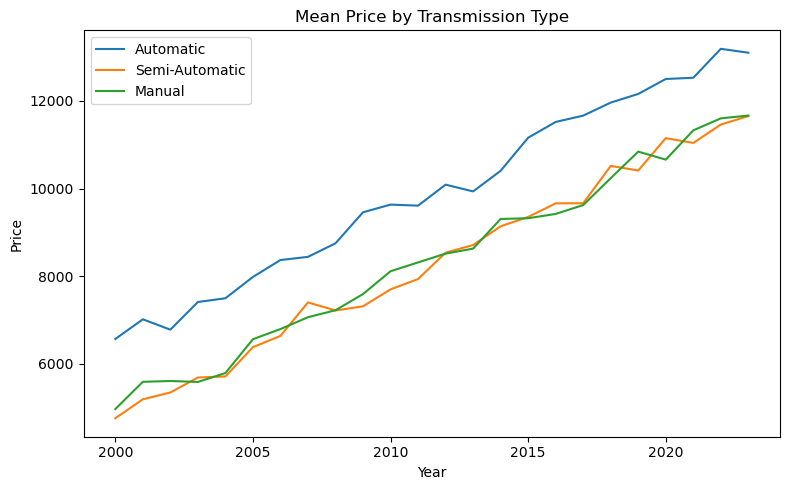

In [ ]:
plt.figure(figsize=(8, 5))

plt.plot(mean_price_automatic.index, mean_price_automatic, label='Automatic')
plt.plot(mean_price_semiautomatic.index, mean_price_semiautomatic, label='Semi-Automatic')
plt.plot(mean_price_manual.index, mean_price_manual, label='Manual')

plt.xlabel('Year')
plt.ylabel('Price')
plt.title('Mean Price by Transmission Type')

plt.legend()

plt.tight_layout()
plt.show()

O gráfico mostra que o preço médio para carros Semi-Automáticos e Manuais estão na mesma faixa, enquanto os carros com transmissão Automática possuem preços mais elevados em média

Analisaremos a variável Fuel_Type da mesma forma

In [ ]:
mean_price_by_fuel = df.groupby(['Fuel_Type', 'Year'])['Price'].mean()
mean_price_by_fuel

Fuel_Type  Year
Diesel     2000     4647.046512
           2001     5105.452830
           2002     5281.834646
           2003     5400.600000
           2004     5722.105263
                       ...     
Petrol     2019     9997.990099
           2020    10828.118812
           2021    10739.145833
           2022    11570.000000
           2023    11529.201754
Name: Price, Length: 96, dtype: float64

In [ ]:
print(df['Fuel_Type'].unique())

['Diesel' 'Hybrid' 'Electric' 'Petrol']


In [ ]:
mean_price_diesel = mean_price_by_fuel.loc['Diesel']
mean_price_hybrid = mean_price_by_fuel.loc['Hybrid']
mean_price_electric = mean_price_by_fuel.loc['Electric']
mean_price_petrol = mean_price_by_fuel.loc['Petrol']

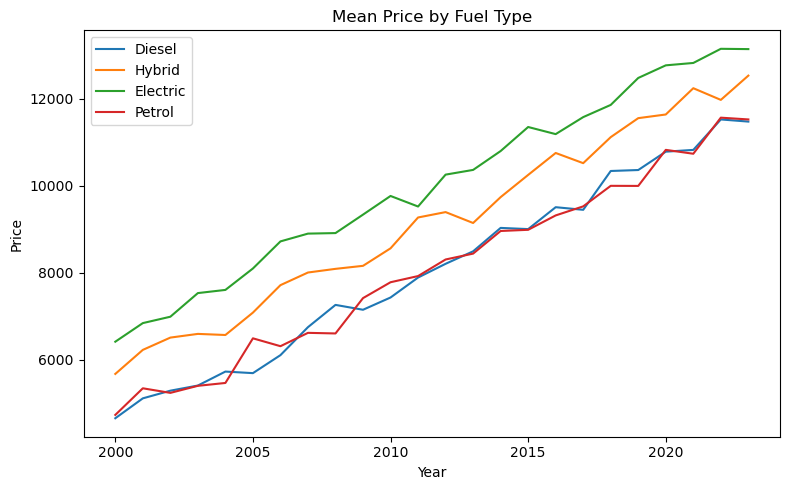

In [ ]:
plt.figure(figsize=(8, 5))

plt.plot(mean_price_diesel.index, mean_price_diesel, label='Diesel')
plt.plot(mean_price_hybrid.index, mean_price_hybrid, label='Hybrid')
plt.plot(mean_price_electric.index, mean_price_electric, label='Electric')
plt.plot(mean_price_petrol.index, mean_price_petrol, label='Petrol')

plt.xlabel('Year')
plt.ylabel('Price')
plt.title('Mean Price by Fuel Type')

plt.legend()

plt.tight_layout()
plt.show()

Os carros com combustível a Diesel e Gasolina são os mais baratos, Elétricos costumam ser os mais caros e Híbridos estão numa faixa intermediária

Analisaremos em seguida o preço médio para cada Marca de carros

In [ ]:
mean_price_by_brand = df.groupby('Brand')['Price'].mean()
mean_price_by_brand

Brand
Audi          8929.373796
BMW           8704.068068
Chevrolet     9015.683948
Ford          8852.570611
Honda         8665.596630
Hyundai       8778.279397
Kia           8880.086066
Mercedes      8980.087049
Toyota        8798.184536
Volkswagen    8928.377451
Name: Price, dtype: float64

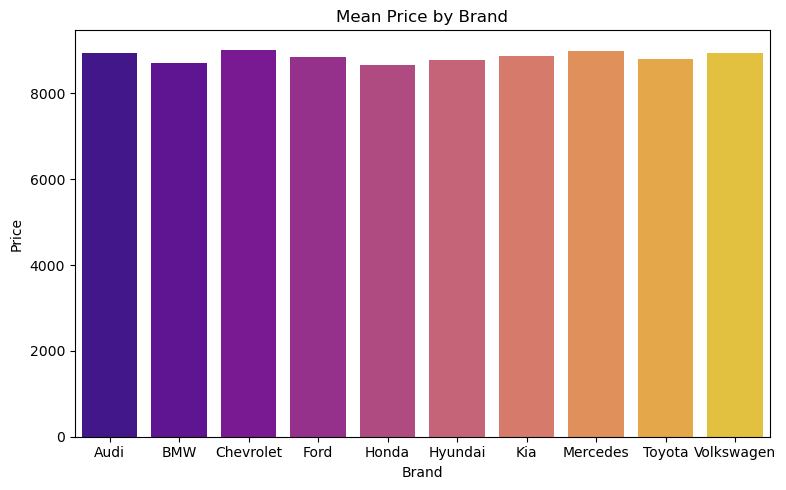

In [ ]:
plt.figure(figsize=(8,5))
sns.barplot(x=mean_price_by_brand.index, y=mean_price_by_brand, palette='plasma', hue=mean_price_by_brand.index)
plt.title('Mean Price by Brand')

plt.tight_layout()
plt.show()

Observando o gráfico de barras, não parece que existe um diferença significativa de preços entre as marcas

Analisaremos os Modelos dos carros da mesma forma

In [ ]:
mean_price_by_model = df.groupby('Model')['Price'].mean()
mean_price_by_model.head()

Model
3 Series    8854.752239
5 Series    8669.218130
A3          8912.316568
A4          8919.962857
Accord      8743.761644
Name: Price, dtype: float64

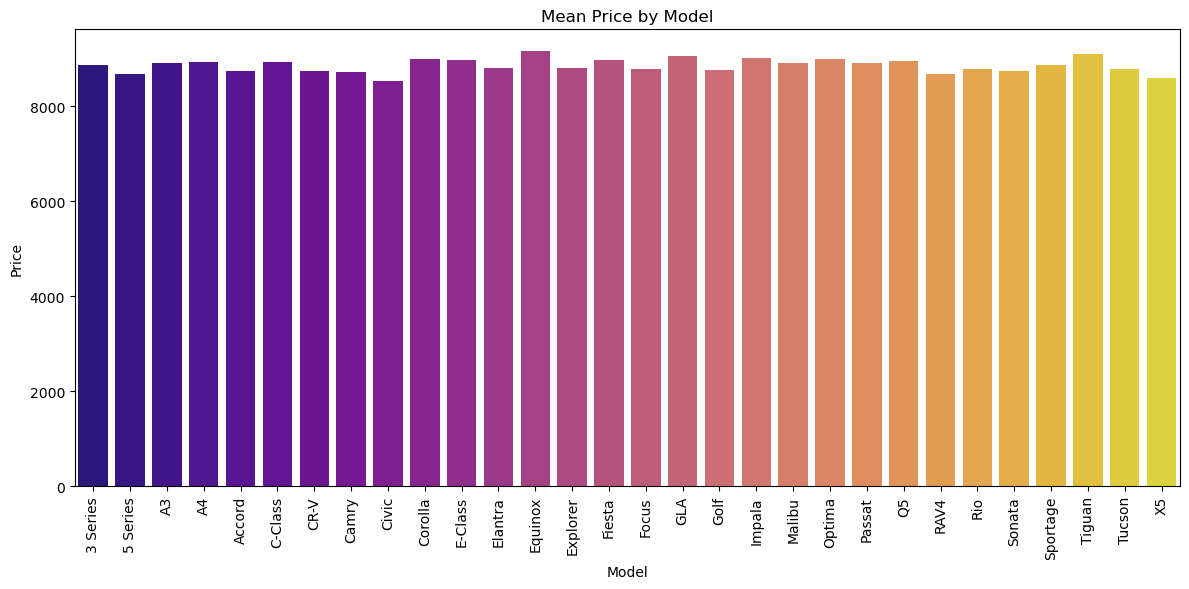

In [ ]:
plt.figure(figsize=(12,6))
sns.barplot(x=mean_price_by_model.index, y=mean_price_by_model, palette='plasma', hue=mean_price_by_model.index)
plt.title('Mean Price by Model')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Também não parece haver uma diferença significativa de preço conforme o modelo mas há algumas variações

## Pré-Processamento de Dados

### Seleção de características

Nem todas as variáveis que foram analisadas possuem utilidade significativa para prever o preço dos carros.  
De acordo com a Análise Exploratória de Dados as variáveis de maior interesse são:  
- Year
- Engine_Size
- Fuel_Type
- Transmission
- Mileage
- Model

### Transformação de características

As variáveis Fuel_Type e Transmission são categóricas. Precisamos transformá-las em tipos válidos para se utilizar um modelo de Machine Learning, utilizaremos One-Hot-Encoding para isso.  
Também normalizaremos os valores para que nenhuma característica domine as outras utilizando MinMaxScale.

In [ ]:
categorical_features = ['Model', 'Fuel_Type', 'Transmission']
numerical_features = ['Year', 'Engine_Size', 'Mileage']
columns_to_drop = ['Brand', 'Doors', 'Owner_Count', 'Price']

categorical_transformer = OneHotEncoder(drop='first')
numerical_transformer = MinMaxScaler()

Será criado pipeline para automatizar o processo

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features),
        ('drop', 'drop', columns_to_drop)
    ]
)

pipeline = Pipeline([
    ('preprocessor', preprocessor)
])

In [ ]:
X = pipeline.fit_transform(df)
columns_transformed = pipeline.named_steps['preprocessor'].get_feature_names_out()

X = pd.DataFrame(X.toarray(), columns=columns_transformed)
X.columns = X.columns.str.replace(r'^(num__|cat__)', '', regex=True)

y = df['Price']


Dados transformados:

In [ ]:
X.head()

,Year,Engine_Size,Mileage,Model_5 Series,Model_A3,Model_A4,Model_Accord,Model_C-Class,Model_CR-V,Model_Camry,...,Model_Sonata,Model_Sportage,Model_Tiguan,Model_Tucson,Model_X5,Fuel_Type_Electric,Fuel_Type_Hybrid,Fuel_Type_Petrol,Transmission_Manual,Transmission_Semi-Automatic
0,0.869565,0.80,0.966648,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.521739,0.25,0.017775,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.869565,0.80,0.771584,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.25,0.536626,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.130435,0.40,0.955558,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [ ]:
y.head()

0     8501
1    12092
2    11171
3    11780
4     2867
Name: Price, dtype: int64

Observe que eliminamos uma de cada variável categórica com o One-Hot-Encoding. Isso foi feito para evitar multicolinearidade no modelo de regressão linear que utilizaremos, o que prejudicaria a inferência do modelo.

### Divisão dos dados

Irei separar os dados em dados de treino (80%) e de teste (20%) para avaliar se o nosso modelo é capaz de lidar com dados não vistos durante o treino.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Previsão e Inferência

### Seleção e treinamento do Modelo

Utilizaremos o algoritmo Regressão Linear

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

### Resultados de previsão

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
rmse = root_mean_squared_error(y_test, y_pred)
print(f'Root Mean Squared Error: {rmse:.2f}')
print(f'RMSE Relativo à média: {(rmse/y_test.mean()):.2f}')

Root Mean Squared Error: 64.89
RMSE Relativo à média: 0.01


In [ ]:
y_true_pred = pd.DataFrame({'True_Price': y_test, 'Predicted_Price': y_pred})
y_true_pred.head(10)

,True_Price,Predicted_Price
6252,2000,1692.485322
4684,11164,11150.632750
1731,14630,14603.108880
4742,7334,7349.228973
4521,10127,10145.455323
6340,7195,7225.089095
576,8292,8294.745527
5202,6229,6261.634686
6363,5776,5805.838532
439,4979,5004.880741


In [ ]:
diff_ytrue_ypred = (y_true_pred['Predicted_Price'] - y_true_pred['True_Price'])
diff_ytrue_ypred.name = 'Error'
diff_ytrue_ypred.head(10)

6252   -307.514678
4684    -13.367250
1731    -26.891120
4742     15.228973
4521     18.455323
6340     30.089095
576       2.745527
5202     32.634686
6363     29.838532
439      25.880741
Name: Error, dtype: float64

In [ ]:
diff_ytrue_ypred.describe()

count    2000.000000
mean        2.207514
std        64.869226
min     -1715.787316
25%        -7.117086
50%         6.692782
75%        19.533563
max        54.284282
Name: Error, dtype: float64

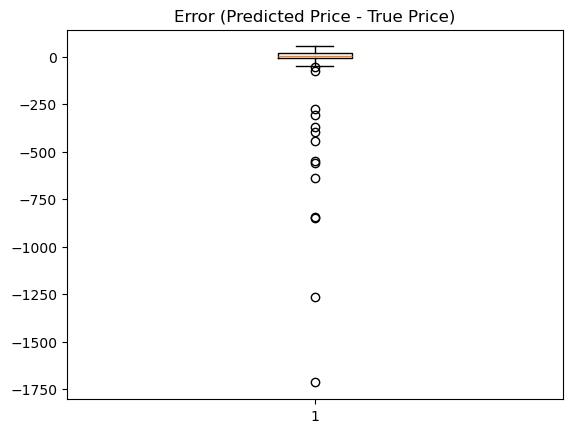

In [ ]:
plt.boxplot(diff_ytrue_ypred)
plt.title('Error (Predicted Price - True Price)')
plt.show()

Os resultados de previsão do modelo foram muito satisfatórios.

- A métrica RMSE é de 64.89
- A métrica RMSE em relação à média de preços é de 0.01

Apesar do erro ser baixo, alguns outliers ainda foram encontrados, com o maior deles chegando a um erro absoluto de 1715.79 (Possívelmente são de dados anômalos que não foram encontrados na fase de Análise Exploratória de Dados)

### Resultados de inferência

Vamos verificar os parâmetros do modelo

In [ ]:
coef = model.coef_
interc = model.intercept_
print(f'Coeficientes do Modelo: {coef}')
print(f'Intercepto do Modelo: {interc}')

Coeficientes do Modelo: [ 6.86555905e+03  3.96943399e+03 -5.96275711e+03 -2.54378415e+00
  1.46311745e+00 -1.08680506e+00  1.04720732e+01  8.32600028e+00
  1.00674610e+01 -1.91925982e+00  1.99739294e+01  3.05017350e+00
  5.17414961e+00  1.80820529e+00  5.51685562e-01  8.38708631e+00
  3.97900222e+00  6.01263097e+00  1.66471697e+01  2.22791573e+00
  2.58382780e+00  3.45163956e+00  1.32374294e+01  3.67622954e+00
  2.36658470e+00  1.31134902e+01  1.28490757e+01  2.91894857e+00
  8.18711035e+00  3.63799152e+00  6.78955865e+00  1.00736029e+01
  1.98697960e+03  9.89305995e+02  1.64585636e-01 -1.48955015e+03
 -1.49212972e+03]
Intercepto do Modelo: 6615.08720123734


Esses parametros estão escalonados pelo MinMaxScaler então faremos o caminho inverso para encontrar os coeficientes ajustados para a escala real

In [ ]:
scaler = pipeline.named_steps['preprocessor'].transformers_[0][1]
min_values = scaler.min_
scale_values = scaler.scale_

In [ ]:
adjusted_coef = coef.copy()
adjusted_coef[:3] = adjusted_coef[:3] * scale_values

In [ ]:
feature_coefficients = pd.Series(adjusted_coef, index=X.columns, name='Coefficients')

In [ ]:
feature_coefficients[:3]

Year           298.502567
Engine_Size    992.358498
Mileage         -0.019881
Name: Coefficients, dtype: float64

In [ ]:
feature_coefficients[32:]

Fuel_Type_Electric             1986.979597
Fuel_Type_Hybrid                989.305995
Fuel_Type_Petrol                  0.164586
Transmission_Manual           -1489.550150
Transmission_Semi-Automatic   -1492.129721
Name: Coefficients, dtype: float64

In [ ]:
print('Coeficientes\n---------------')
print(f'Year: {feature_coefficients.loc["Year"]:.2f}')
print(f'Engine_Size: {feature_coefficients.loc["Engine_Size"]:.2f}')
print(f'Mileage: {feature_coefficients.loc["Mileage"]:.4f}')
print(f'Fuel_Type_Electric: {feature_coefficients.loc["Fuel_Type_Electric"]:.2f}')
print(f'Fuel_Type_Hybrid: {feature_coefficients.loc["Fuel_Type_Hybrid"]:.2f}')
print(f'Fuel_Type_Petrol: {feature_coefficients.loc["Fuel_Type_Petrol"]:.2f}')
print(f'Transmission_Manual: {feature_coefficients.loc["Transmission_Manual"]:.2f}')
print(f'Transmission_Semi-Automatic: {feature_coefficients.loc["Transmission_Semi-Automatic"]:.2f}')

Coeficientes
---------------
Year: 298.50
Engine_Size: 992.36
Mileage: -0.0199
Fuel_Type_Electric: 1986.98
Fuel_Type_Hybrid: 989.31
Fuel_Type_Petrol: 0.16
Transmission_Manual: -1489.55
Transmission_Semi-Automatic: -1492.13


## Salvando o modelo

In [ ]:
joblib.dump(pipeline, '../artifacts/preprocessing_pipeline.pkl')
joblib.dump(model, '../artifacts/linear_regression_model.pkl')

['../artifacts/linear_regression_model.pkl']

## Conclusões

Foi utilizado um modelo de regressão linear para esse projeto

### Previsão

Os resultados de previsão do modelo foram muito satisfatórios.

- A métrica RMSE é de 64.89
- A métrica RMSE em relação à média de preços é de 0.01

Apesar do erro ser baixo, alguns outliers ainda foram encontrados, com o maior deles chegando a um erro absoluto de 1715.79 (Possívelmente são de dados anômalos que não foram encontrados na fase de Análise Exploratória de Dados)

### Inferência

- Os carros desvalorizam \$299 para cada ano decorrido.  
- Os carros valem \$992 a mais para cada litro de tamanho do motor.  
- Os carros desvalorizam \$0.02 para cada kilômetro percorrido.  
- Carros elétricos são em média \$1987 mais caros em relação aos carros a  diesel.  
- Carros híbridos são em média \$989 mais caros em relação aos carros a diesel.  
- Carros movidos a gasolina não possuem uma diferença significante em relação aos carros a diesel.  
- Carros com transmissão manual são em média \$1490 mais baratos que carros com transmissão automática.  
- Carros com transmissão semi-automática são em média \$1492 mais baratos que carros com transmissão automática.  

### Gráficos

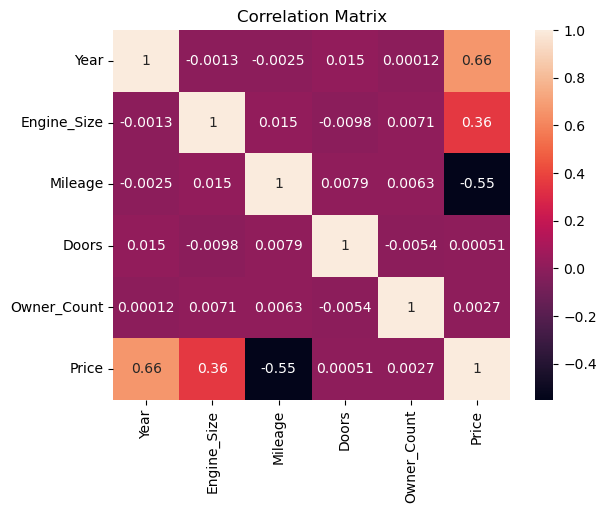

In [ ]:
corr_matrix = df[['Year', 'Engine_Size', 'Mileage', 'Doors', 'Owner_Count', 'Price']].corr()
plt.title('Correlation Matrix')
sns.heatmap(corr_matrix, annot=True);

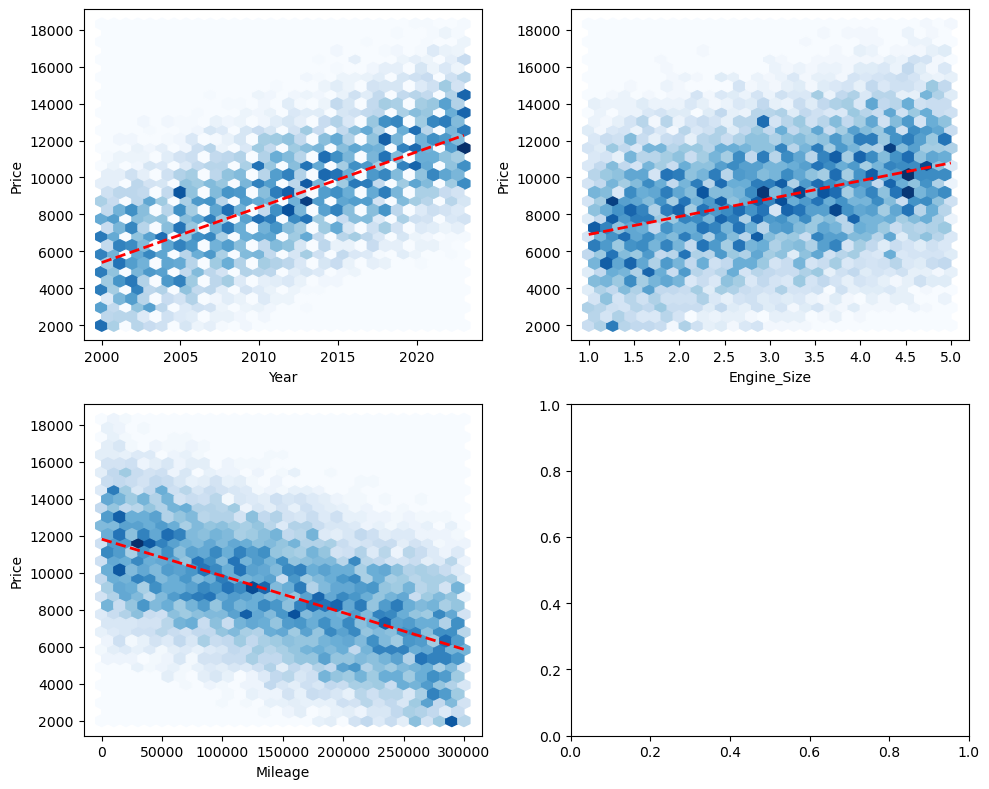

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8))

plot_hexbin_fit(ax[0,0], df, 'Year', 'Price')
plot_hexbin_fit(ax[0,1], df, 'Engine_Size', 'Price')
plot_hexbin_fit(ax[1,0], df, 'Mileage', 'Price')

plt.tight_layout()
plt.show()

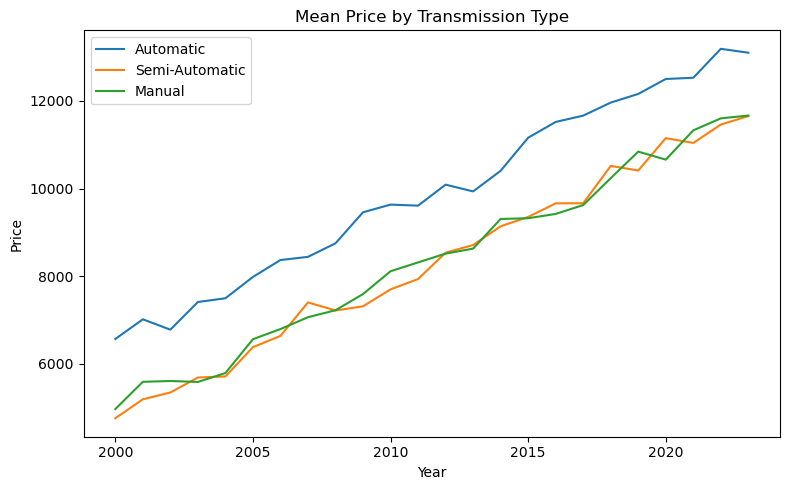

In [ ]:
plt.figure(figsize=(8, 5))

plt.plot(mean_price_automatic.index, mean_price_automatic, label='Automatic')
plt.plot(mean_price_semiautomatic.index, mean_price_semiautomatic, label='Semi-Automatic')
plt.plot(mean_price_manual.index, mean_price_manual, label='Manual')

plt.xlabel('Year')
plt.ylabel('Price')
plt.title('Mean Price by Transmission Type')

plt.legend()

plt.tight_layout()
plt.show()

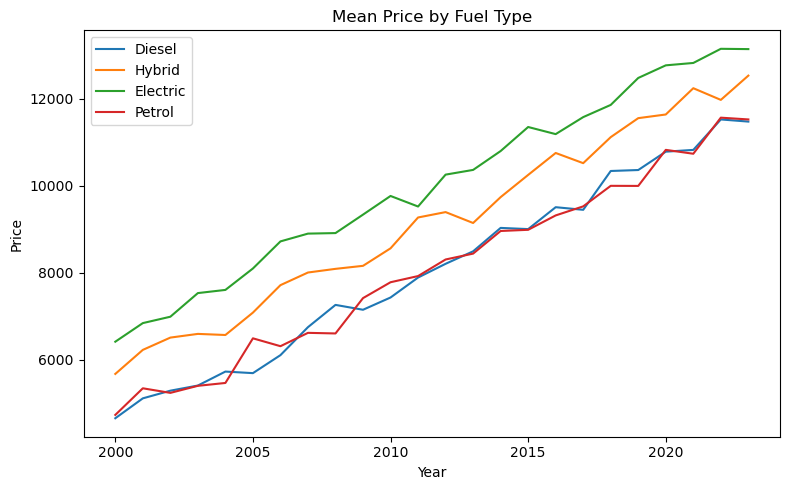

In [ ]:
plt.figure(figsize=(8, 5))

plt.plot(mean_price_diesel.index, mean_price_diesel, label='Diesel')
plt.plot(mean_price_hybrid.index, mean_price_hybrid, label='Hybrid')
plt.plot(mean_price_electric.index, mean_price_electric, label='Electric')
plt.plot(mean_price_petrol.index, mean_price_petrol, label='Petrol')

plt.xlabel('Year')
plt.ylabel('Price')
plt.title('Mean Price by Fuel Type')

plt.legend()

plt.tight_layout()
plt.show()

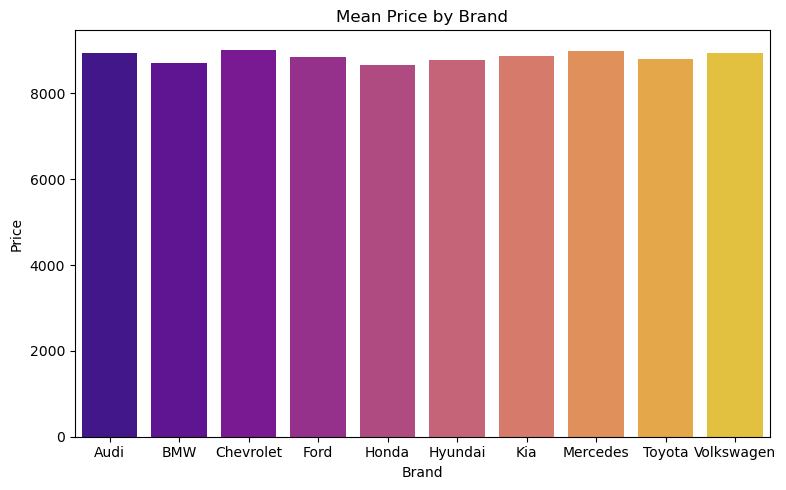

In [ ]:
plt.figure(figsize=(8,5))
sns.barplot(x=mean_price_by_brand.index, y=mean_price_by_brand, palette='plasma', hue=mean_price_by_brand.index)
plt.title('Mean Price by Brand')

plt.tight_layout()
plt.show()

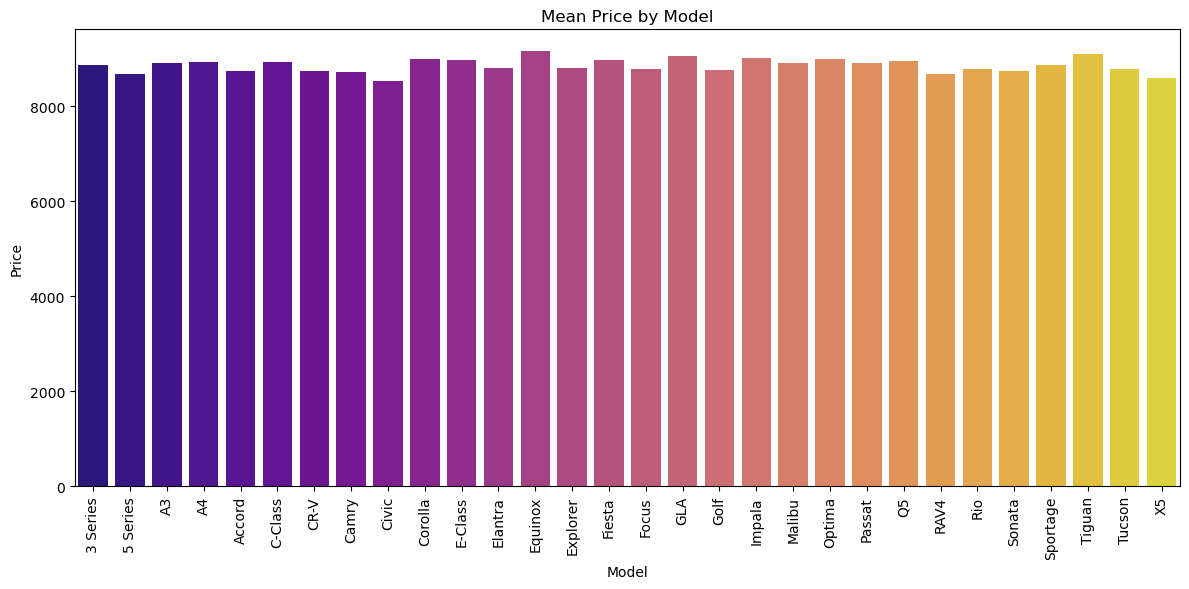

In [ ]:
plt.figure(figsize=(12,6))
sns.barplot(x=mean_price_by_model.index, y=mean_price_by_model, palette='plasma', hue=mean_price_by_model.index)
plt.title('Mean Price by Model')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

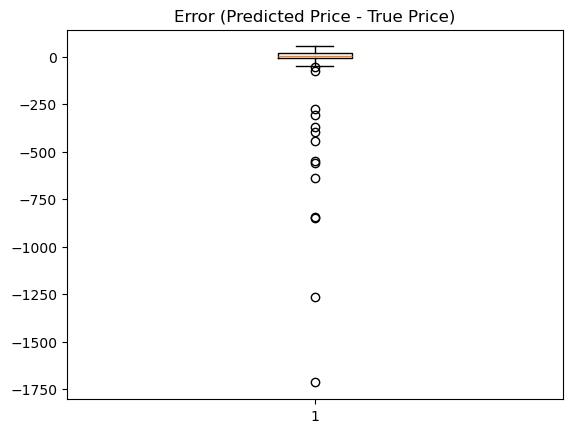

In [ ]:
plt.boxplot(diff_ytrue_ypred)
plt.title('Error (Predicted Price - True Price)')
plt.show()